# Importing Libraries

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage import color
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from tqdm import tqdm
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import FocalLoss
import gc
import wandb

/home/thomas/research/research_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Hyperparameters

In [2]:
learning_rate = 1e-04
num_epochs = 50
batch_size = 8
img_resize = 560
crop_size = 512
mean, std = [0.4194, 0.4612, 0.3479], [0.2038, 0.1898, 0.2043]
base_model = 'resnet34'
p_img_aug = 0.5
inv_transforms = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ],
                                        std = [ 1/std[0], 1/std[1], 1/std[2] ]),
                                    transforms.Normalize(mean = [-mean[0], -mean[1], -mean[2]],
                                        std = [ 1., 1., 1. ])])
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setting first experiment
wandb.init(project='scene_segmentation', name="dice_loss", notes = "Running the segmentation of scene using unet and dice loss")
wandb.config = {
    'batch_size': batch_size,
    'crop_size': crop_size,
    'mean': mean,
    'std': std,
    'num_epochs': num_epochs,
    'base_model': base_model,
    'p_img_aug': p_img_aug,
    'loss': 'dice_loss',
    'metrics': 'iou_score'
}

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aniketthomas. Use `wandb login --relogin` to force relogin


## Helper Functions

In [3]:
# Calculate mean and std_dev for normalization
def mean_and_std(dataloader):
    channel_sum, channel_squared_sum = 0, 0
    for idx, (imgs, _) in tqdm(enumerate(dataloader, start = 1), total=len(dataloader)):
        imgs = imgs.to(device, non_blocking = True)
        channel_sum += torch.mean(imgs, dim = [0, 2, 3])
        channel_squared_sum += torch.mean(imgs**2, dim = [0, 2, 3])
    mean = channel_sum / (idx)
    std = (channel_squared_sum/(idx) - mean**2)**0.5
    return mean, std

## Loading data

In [4]:
base_data_dir = pathlib.Path('data/FloodNet-Supervised_v1.0/')
train_dir = base_data_dir/'train'
test_dir = base_data_dir/'test'
valid_dir = base_data_dir/'val'
train_img_dir, train_mask_dir = train_dir/'train-org-img', train_dir/'train-label-img'
valid_img_dir, valid_mask_dir = valid_dir/'val-org-img', valid_dir/'val-label-img'
test_img_dir, test_mask_dir = test_dir/'test-org-img', test_dir/'test-label-img'

In [5]:
# Fetching all the jpgs from the img folder
# the glob module is used to retrieve files/pathnames matching a specified pattern
train_images = list(train_img_dir.glob('*.jpg'))
valid_images = list(valid_img_dir.glob('*.jpg'))
test_images = list(test_img_dir.glob('*.jpg'))
print(f"No of Train Images: {len(train_images)}, No of Valid Images: {len(valid_images)}, No of Test Images: {len(test_images)}")
train_images[:5]

No of Train Images: 1445, No of Valid Images: 450, No of Test Images: 448


[PosixPath('data/FloodNet-Supervised_v1.0/train/train-org-img/9036.jpg'),
 PosixPath('data/FloodNet-Supervised_v1.0/train/train-org-img/6525.jpg'),
 PosixPath('data/FloodNet-Supervised_v1.0/train/train-org-img/10182.jpg'),
 PosixPath('data/FloodNet-Supervised_v1.0/train/train-org-img/7037.jpg'),
 PosixPath('data/FloodNet-Supervised_v1.0/train/train-org-img/6992.jpg')]

In [6]:
def label_mask_path(mask_dir, image_path):
    return mask_dir/f'{image_path.stem}_lab.png'
idx = 42
img_path = train_images[idx]
label_path = label_mask_path(train_mask_dir, img_path)
print(img_path)
print(label_path)

data/FloodNet-Supervised_v1.0/train/train-org-img/6960.jpg
data/FloodNet-Supervised_v1.0/train/train-label-img/6960_lab.png


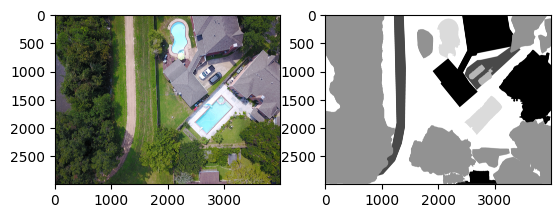

In [7]:
plt.subplot(121)
img = Image.open(img_path)
img = np.asarray(img)
plt.imshow(img)
plt.subplot(122)
mask = Image.open(label_path)
mask = np.asarray(mask)
plt.imshow(mask, cmap = 'gray');

In [8]:
# unique_labels = []
# for img in tqdm(train_images):
#     mask_path = label_mask_path(train_mask_dir, img)
#     mask = np.asarray(Image.open(mask_path))
#     unique_label = np.unique(mask).tolist()
#     unique_labels.extend(unique_label)
# print(f"No of unique labels: {len(set(unique_labels))}")

In [9]:
class SatelliteDataset(Dataset):
    def __init__(self, imgs_dir, masks_dir, images, transforms = None):
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        self.images = images
        self.transforms = transforms

    def __len__(self):
        return len(self.images)
         
    def __getitem__(self, idx):
        current_img_path = self.images[idx]
        current_label_path = self.label_mask_path(current_img_path)
        img = np.asarray(Image.open(current_img_path)).copy() / 255.
        mask = np.asarray(Image.open(current_label_path)).copy()
        if self.transforms:
            transformed = self.transforms(image = img, mask = mask)
            img = transformed['image']
            mask = transformed['mask']
        return img, mask

    def label_mask_path(self, image_path):
        return self.masks_dir/f'{image_path.stem}_lab.png'

In [10]:
train_augmentation = A.Compose([A.LongestMaxSize(max_size=img_resize, interpolation=1),
                                A.PadIfNeeded(min_height=img_resize, min_width=img_resize),
                                A.HorizontalFlip(p = p_img_aug),
                                A.RandomCrop(height = crop_size, width = crop_size),
                                A.Normalize(mean = mean, std = std, max_pixel_value=1),
                                ToTensorV2(),
                                ])
train_dataset = SatelliteDataset(train_img_dir, train_mask_dir, train_images, train_augmentation)
trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=8, pin_memory=True)

valid_augmentation = A.Compose([A.LongestMaxSize(max_size=crop_size, interpolation=1),
                                A.PadIfNeeded(min_height=crop_size, min_width=crop_size),
                                A.Normalize(mean = mean, std = std, max_pixel_value=1),
                                ToTensorV2(),
                                ])
valid_dataset = SatelliteDataset(valid_img_dir, valid_mask_dir, valid_images, valid_augmentation)
validloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle = True, num_workers=8, pin_memory=True)

In [11]:
print('No. of batches in train loader = ',len(trainloader))
print ('Size of training dataset = ',len(train_dataset) )

No. of batches in train loader =  181
Size of training dataset =  1445


In [12]:
print('No. of batches in train loader = ',len(validloader))
print ('Size of training dataset = ',len(valid_dataset) )

No. of batches in train loader =  57
Size of training dataset =  450


In [13]:
# mean_and_std(trainloader)

In [14]:
test_augmentation = A.Compose([A.LongestMaxSize(max_size=crop_size, interpolation=1),
                                A.PadIfNeeded(min_height=crop_size, min_width=crop_size),
                                # A.RandomCrop(height = crop_size, width = crop_size),
                                A.Normalize(mean = mean, std = std, max_pixel_value=1),
                                ToTensorV2(),
                                ])
test_dataset = SatelliteDataset(test_img_dir, test_mask_dir, test_images, test_augmentation)
testloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=8, pin_memory=True)

In [15]:
print ('No. of batches in test loader = ',len(testloader))
print ('Size of testing dataset = ',len(test_dataset) )

No. of batches in test loader =  56
Size of testing dataset =  448


In [16]:
train_imgs, train_masks = next(iter(trainloader))
train_imgs.shape, train_masks.shape

(torch.Size([8, 3, 512, 512]), torch.Size([8, 512, 512]))

In [17]:
valid_imgs, valid_masks = next(iter(validloader))
valid_imgs.shape, valid_masks.shape

(torch.Size([8, 3, 512, 512]), torch.Size([8, 512, 512]))

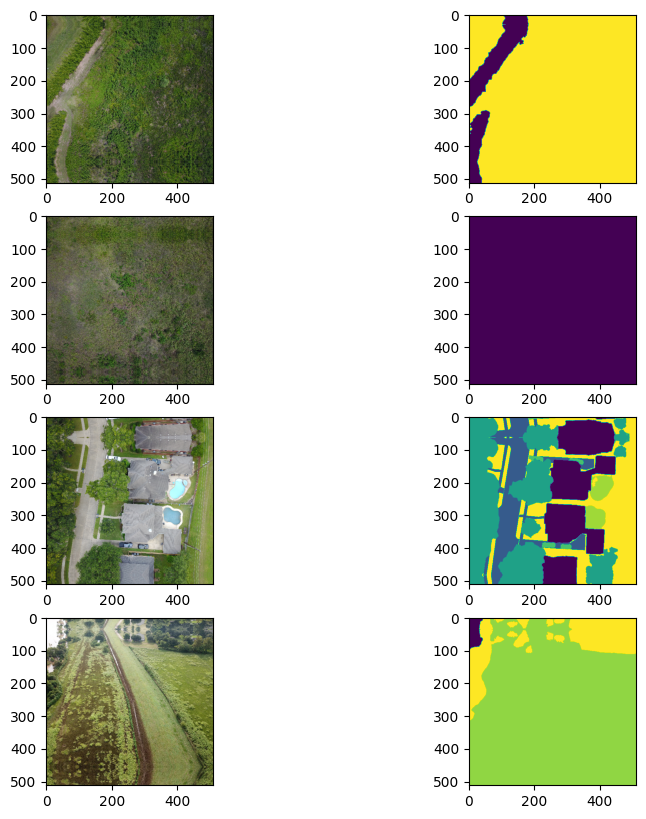

In [18]:
fig, axes = plt.subplots(4, 2, figsize = (10,10))
for i in range(4):
    # (H x W x C) -> (C x H x W)
    # Denormalizing input
    img = inv_transforms(train_imgs[i])
    img, mask = np.transpose(img.cpu().detach().numpy(), (1,2,0)), train_masks[i]
    img = np.clip(img, 0, 1)
    axes[i, 0].imshow(img)
    #axes[i, 0].axis('off')
    axes[i, 1].imshow(mask)
    #axes[i, 1].axis('off')

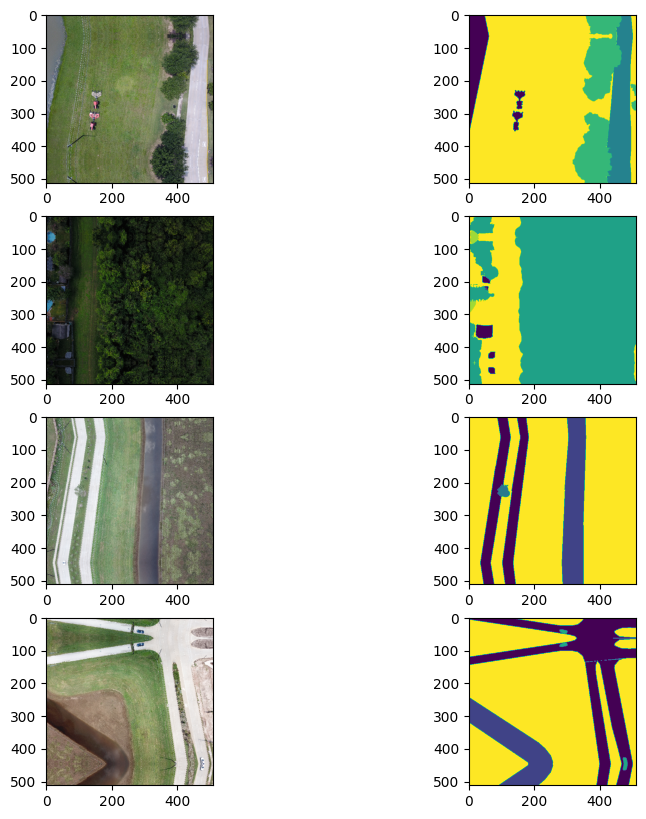

In [19]:
fig, axes = plt.subplots(4, 2, figsize = (10,10))
for i in range(4):
    # (H x W x C) -> (C x H x W)
    img = inv_transforms(valid_imgs[i])
    img, mask = np.transpose(img.cpu().detach().numpy(), (1,2,0)), valid_masks[i]
    img = np.clip(img, 0, 1)
    axes[i, 0].imshow(img)
    #axes[i, 0].axis('off')
    axes[i, 1].imshow(mask)
    #axes[i, 1].axis('off')

### Segmentation Model

In [20]:
class SegmentationModel(nn.Module):
    def __init__(self, base_model):
        super(SegmentationModel,self).__init__()
        self.arc = smp.Unet(encoder_name = base_model, encoder_weights = 'imagenet', classes = 10)

    def forward(self, images):
        logits = self.arc(images)
        return logits

### Train and Test Function 

In [21]:
def train_fn(data_loader, model, optimizer, criterion, train = True):
    total_loss = 0.0
    pbar = tqdm(data_loader, total = len(data_loader), leave=False)
    for imgs,masks in pbar:
        imgs = imgs.to(device, non_blocking = True)
        masks = masks.to(device, non_blocking = True).to(torch.int64)
        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, masks)
        if train:
            loss.backward()
            optimizer.step()
        pbar.set_postfix({'Loss': loss.item()})
        total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    return avg_loss

def calculate_iou(dataloader, model):
    total_iou = 0.0
    model.eval()
    with torch.no_grad():
        model = model.to(device)
        for imgs, masks in dataloader:
            imgs = imgs.to(device, non_blocking = True)
            masks = masks.to(device, non_blocking = True)
            out = model(imgs)
            out = torch.max(out, dim = 1)[1]
            tp, fp, fn, tn = smp.metrics.get_stats(out, masks, mode = 'multiclass', num_classes=10)
            iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction='macro-imagewise')
            total_iou+=iou_score
        return total_iou/len(dataloader)

## Model Building

In [22]:
model = SegmentationModel(base_model)
model = model.to(device)
criterion = DiceLoss(mode = 'multiclass',classes=10)
# criterion = FocalLoss(mode = "multiclass", gamma = 2)
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

### Training model

In [23]:
def log_visualization(dataloader, title):
    imgs, masks = next(iter(dataloader))
    imgs = imgs.to(device)
    preds = model(imgs)
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    fig, axes = plt.subplots(len(imgs), 3, figsize = (10,25))
    for i in range(len(imgs)):
        # (H x W x C) -> (C x H x W)
        # Denormalizing input
        img = inv_transforms(imgs[i])
        img, mask = np.transpose(img.cpu().detach().numpy(), (1,2,0)), masks[i]
        img = np.clip(img, 0, 1)
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Original Image')
        axes[i, 0].imshow(img)
        axes[i, 1].axis('off')
        axes[i, 1].set_title('True Mask')
        axes[i, 1].imshow(mask)
        _, pred_mask = torch.max(preds[i], dim = 0)
        pred_mask = pred_mask.cpu().detach()
        axes[i, 2].axis('off')
        axes[i, 2].set_title('Predicted Mask')
        axes[i, 2].imshow(pred_mask)
    wandb.log({title: fig})
    fig.clear()
    plt.close(fig)
log_visualization(validloader, 'Valid Sample (Before Training)')
log_visualization(trainloader, 'Train Sample (Before Training)');

<Figure size 640x480 with 0 Axes>

In [24]:
best_valid_loss = np.Inf
train_losses, valid_losses = [], []
train_iou_scores, valid_iou_scores = [], []
for i in range(num_epochs):
    model.train()
    train_loss = train_fn (trainloader, model, optimizer, criterion, train = True)
    torch.cuda.empty_cache()
    gc.collect()
    model.eval()
    with torch.no_grad():
        valid_loss = train_fn (validloader, model, optimizer, criterion, train = False)
        train_iou_score = calculate_iou(trainloader, model)
        valid_iou_score = calculate_iou(validloader, model)
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(),'best-model.pt')
        print("Model Saved")
        best_valid_loss = valid_loss
    valid_losses.append(valid_loss)
    train_losses.append(train_loss)
    train_iou_scores.append(train_iou_score)
    valid_iou_scores.append(valid_iou_score)
    print (f"Epoch : {i+1}\nTrain Loss = {train_loss:.5f}, Train IOU Score = {train_iou_score:.4f}\nValid Loss = {valid_loss:.5f}, valid IOU Score = {valid_iou_score:.4f}")
    wandb.log({"Epoch": i+1, 'train_dice_loss': train_loss, 'train_iou_score': train_iou_score, 'valid_iou_score':valid_iou_score, 'valid_dice_loss': valid_loss})
    if i%5 == 0:
        log_visualization(trainloader, f"Epoch: Train Sample")
        log_visualization(validloader, f"Epoch: Valid Sample")

Model Saved
Epoch : 1
Train Loss = 0.64213, Train IOU Score = 0.2309
Valid Loss = 0.54865, valid IOU Score = 0.2240


Model Saved
Epoch : 2
Train Loss = 0.53446, Train IOU Score = 0.3520
Valid Loss = 0.47034, valid IOU Score = 0.3347


Model Saved
Epoch : 3
Train Loss = 0.43373, Train IOU Score = 0.4778
Valid Loss = 0.42812, valid IOU Score = 0.4689


Model Saved
Epoch : 4
Train Loss = 0.36881, Train IOU Score = 0.6260
Valid Loss = 0.33607, valid IOU Score = 0.6043


Model Saved
Epoch : 5
Train Loss = 0.32754, Train IOU Score = 0.6160
Valid Loss = 0.31859, valid IOU Score = 0.5999


Model Saved
Epoch : 6
Train Loss = 0.29314, Train IOU Score = 0.6212
Valid Loss = 0.26842, valid IOU Score = 0.6064


Model Saved
Epoch : 7
Train Loss = 0.26148, Train IOU Score = 0.6709
Valid Loss = 0.26111, valid IOU Score = 0.6482


Model Saved
Epoch : 8
Train Loss = 0.23377, Train IOU Score = 0.6821
Valid Loss = 0.24330, valid IOU Score = 0.6618


Epoch : 9
Train Loss = 0.22569, Train IOU Score = 0.6619
Valid Loss = 0.26569, valid IOU Score = 0.6374


Model Saved
Epoch : 10
Train Loss = 0.22316, Train IOU Score = 0.6515
Valid Loss = 0.22853, valid IOU Score = 0.6371


Model Saved
Epoch : 11
Train Loss = 0.21956, Train IOU Score = 0.7227
Valid Loss = 0.22510, valid IOU Score = 0.7044


Model Saved
Epoch : 12
Train Loss = 0.21270, Train IOU Score = 0.7523
Valid Loss = 0.22314, valid IOU Score = 0.7324


Epoch : 13
Train Loss = 0.20473, Train IOU Score = 0.7079
Valid Loss = 0.22469, valid IOU Score = 0.6838


Model Saved
Epoch : 14
Train Loss = 0.20666, Train IOU Score = 0.7236
Valid Loss = 0.21495, valid IOU Score = 0.7005


Model Saved
Epoch : 15
Train Loss = 0.19554, Train IOU Score = 0.7382
Valid Loss = 0.20648, valid IOU Score = 0.7136


Epoch : 16
Train Loss = 0.19616, Train IOU Score = 0.7476
Valid Loss = 0.21463, valid IOU Score = 0.7260


Epoch : 17
Train Loss = 0.18946, Train IOU Score = 0.7383
Valid Loss = 0.20740, valid IOU Score = 0.7134


Epoch : 18
Train Loss = 0.19447, Train IOU Score = 0.7274
Valid Loss = 0.21485, valid IOU Score = 0.7035


Model Saved
Epoch : 19
Train Loss = 0.18799, Train IOU Score = 0.7804
Valid Loss = 0.20512, valid IOU Score = 0.7502


Model Saved
Epoch : 20
Train Loss = 0.18719, Train IOU Score = 0.7879
Valid Loss = 0.20124, valid IOU Score = 0.7613


Epoch : 21
Train Loss = 0.18062, Train IOU Score = 0.7599
Valid Loss = 0.20912, valid IOU Score = 0.7359


Epoch : 22
Train Loss = 0.18403, Train IOU Score = 0.7355
Valid Loss = 0.20909, valid IOU Score = 0.7113


Epoch : 23
Train Loss = 0.18173, Train IOU Score = 0.6886
Valid Loss = 0.21417, valid IOU Score = 0.6591


Model Saved
Epoch : 24
Train Loss = 0.16979, Train IOU Score = 0.7810
Valid Loss = 0.19783, valid IOU Score = 0.7460


Epoch : 25
Train Loss = 0.17648, Train IOU Score = 0.8053
Valid Loss = 0.20871, valid IOU Score = 0.7765


Epoch : 26
Train Loss = 0.16836, Train IOU Score = 0.7804
Valid Loss = 0.20264, valid IOU Score = 0.7500


Model Saved
Epoch : 27
Train Loss = 0.17652, Train IOU Score = 0.7813
Valid Loss = 0.19781, valid IOU Score = 0.7492


Epoch : 28
Train Loss = 0.16944, Train IOU Score = 0.6989
Valid Loss = 0.30968, valid IOU Score = 0.6602


Epoch : 29
Train Loss = 0.18505, Train IOU Score = 0.7699
Valid Loss = 0.21607, valid IOU Score = 0.7375


Epoch : 30
Train Loss = 0.16215, Train IOU Score = 0.8023
Valid Loss = 0.20603, valid IOU Score = 0.7720


Epoch : 31
Train Loss = 0.16873, Train IOU Score = 0.7509
Valid Loss = 0.23035, valid IOU Score = 0.7173


Traceback (most recent call last):
  File "/home/thomas/research/research_env/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/thomas/research/research_env/lib/python3.9/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/thomas/research/research_env/lib/python3.9/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/thomas/research/research_env/lib/python3.9/shutil.py", line 740, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/thomas/research/research_env/lib/python3.9/shutil.py", line 738, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-41dr9de5'


Model Saved
Epoch : 32
Train Loss = 0.15679, Train IOU Score = 0.7879
Valid Loss = 0.19395, valid IOU Score = 0.7641


Epoch : 33
Train Loss = 0.16946, Train IOU Score = 0.7729
Valid Loss = 0.21742, valid IOU Score = 0.7506


Epoch : 34
Train Loss = 0.15510, Train IOU Score = 0.8159
Valid Loss = 0.19404, valid IOU Score = 0.7875


Model Saved
Epoch : 35
Train Loss = 0.15882, Train IOU Score = 0.8395
Valid Loss = 0.19200, valid IOU Score = 0.8115


Epoch : 36
Train Loss = 0.16668, Train IOU Score = 0.7583
Valid Loss = 0.20223, valid IOU Score = 0.7327


Epoch : 37
Train Loss = 0.17046, Train IOU Score = 0.8055
Valid Loss = 0.21646, valid IOU Score = 0.7692


Epoch : 38
Train Loss = 0.17134, Train IOU Score = 0.8071
Valid Loss = 0.20599, valid IOU Score = 0.7802


Model Saved
Epoch : 39
Train Loss = 0.15599, Train IOU Score = 0.8246
Valid Loss = 0.18959, valid IOU Score = 0.7873


Epoch : 40
Train Loss = 0.15550, Train IOU Score = 0.8038
Valid Loss = 0.20378, valid IOU Score = 0.7695


Epoch : 41
Train Loss = 0.15354, Train IOU Score = 0.8122
Valid Loss = 0.19779, valid IOU Score = 0.7763


Epoch : 42
Train Loss = 0.15092, Train IOU Score = 0.8187
Valid Loss = 0.19752, valid IOU Score = 0.7833


Epoch : 43
Train Loss = 0.14835, Train IOU Score = 0.8059
Valid Loss = 0.20081, valid IOU Score = 0.7694


Model Saved
Epoch : 44
Train Loss = 0.15109, Train IOU Score = 0.8403
Valid Loss = 0.18730, valid IOU Score = 0.8082


Epoch : 45
Train Loss = 0.14871, Train IOU Score = 0.8072
Valid Loss = 0.19756, valid IOU Score = 0.7780


Epoch : 46
Train Loss = 0.15193, Train IOU Score = 0.8289
Valid Loss = 0.19653, valid IOU Score = 0.8012


Epoch : 47
Train Loss = 0.14416, Train IOU Score = 0.8219
Valid Loss = 0.19486, valid IOU Score = 0.7985


Epoch : 48
Train Loss = 0.15523, Train IOU Score = 0.7619
Valid Loss = 0.20015, valid IOU Score = 0.7272


Epoch : 49
Train Loss = 0.15217, Train IOU Score = 0.8070
Valid Loss = 0.19755, valid IOU Score = 0.7762


Epoch : 50
Train Loss = 0.14981, Train IOU Score = 0.8391
Valid Loss = 0.19811, valid IOU Score = 0.8106


<Figure size 640x480 with 0 Axes>

In [25]:
log_visualization(validloader, 'Valid Sample (After Training)')
log_visualization(trainloader, 'Train Sample (After Training)');

<Figure size 640x480 with 0 Axes>